In [1]:
import os
import time

import numpy as np
import pandas 
import geopandas

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import re
from pprint import pprint


thisyear = 2018
this_state = 'MO'

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'
#separated_roads_dir = output_dir = '/home/idies/workspace/Temporary/raddick/jordanraddick.com_temp/roads/{0:}/'.format(this_state.lower())


water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

scale = 1
#map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

district_color_cycle = ['red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite']
inverse_color_cycle = ['green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'maroon', 'seagreen']

debug = 1
g = 0

def makebox(manual_xlim, manual_ylim):

    points = []
    points.append(Point(manual_xlim[0],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[1]))
    points.append(Point(manual_xlim[1],manual_ylim[0]))
    points.append(Point(manual_xlim[0],manual_ylim[0]))
    
    coords = [(p.x, p.y) for p in points]    
    metrobox = Polygon(coords)
    
    return metrobox 

print('ok')

ok


# Get congressional district shapefiles

WITH data on metro and city areas as a percentage of total district area.

This assumes that you have already run <code>districts-cities.ipynb</code>.

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.0 seconds.


# Load block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 142.9 seconds!


## Look up state and county names from numbers

In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 14.2 seconds!


## Get population data, and join onto shapefiles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 4 seconds!


# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

## Get what has been matched so far

In [6]:
s = time.time()
print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_7.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs


cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

print('backing up...')
cd_gdf_bk = cd_gdf
bg_gdf_bk = bg_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




reading districts that have been matched so far...
backing up...
Kept 166,509 block groups in 1.1 seconds!


## States with 8 districts

These are harder, because first we have to know which block groups overlap multiple districts.

Create a function to mark those.

### Create function to mark block groups with the districts they overlap

In [7]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    if (debug > 0):    
        print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,100) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')
assembler_gdf.groupby('STUSAB')['block_based_district'].max().sort_values(ascending=False)


defined district-marking function!


STUSAB
AL    7.0
SC    7.0
CO    7.0
KY    6.0
LA    6.0
CT    5.0
OR    5.0
OK    5.0
MS    4.0
NV    4.0
KS    4.0
IA    4.0
AR    4.0
UT    4.0
NM    3.0
NE    3.0
WV    3.0
ID    2.0
NH    2.0
HI    2.0
ME    2.0
RI    2.0
WY    1.0
MT    1.0
DE    1.0
ND    1.0
SD    1.0
VT    1.0
AK    1.0
Name: block_based_district, dtype: float64

## Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [8]:
s = time.time()

print('getting from backup...')
bg_gdf = bg_gdf_bk
assembler_gdf = assembler_gdf_bk

e = time.time()
g = g + (e-s)

for this_state in ['MD', 'MN', 'MO', 'WI']:
    s = time.time()
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)
    
    
    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        
    
    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')
        
    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))
    
    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1
    
    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=False)
    if (debug > 0):
        print("\n")
    e = time.time()
    g = g + (e-s)

    print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

print('backing up...')
assembler_gdf_justparsed = assembler_gdf

print('GRAND TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# assembler_gdf.sample(2).T

#assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()


getting from backup...


Processing Maryland...
	Assigning bitmask values to block groups in Maryland...
		processing row 1 of 3,926...
		processing row 101 of 3,926...
		processing row 201 of 3,926...
		processing row 301 of 3,926...
		processing row 401 of 3,926...
		processing row 501 of 3,926...
		processing row 601 of 3,926...
		processing row 701 of 3,926...
		processing row 801 of 3,926...
		processing row 901 of 3,926...
		processing row 1,001 of 3,926...
		processing row 1,101 of 3,926...
		processing row 1,201 of 3,926...
		processing row 1,301 of 3,926...
		processing row 1,401 of 3,926...
		processing row 1,501 of 3,926...
		processing row 1,601 of 3,926...
		processing row 1,701 of 3,926...
		processing row 1,801 of 3,926...
		processing row 1,901 of 3,926...
		processing row 2,001 of 3,926...
		processing row 2,101 of 3,926...
		processing row 2,201 of 3,926...
		processing row 2,301 of 3,926...
		processing row 2,401 of 3,926...
		processing row 2,501 of 3,926...
		proce

In [9]:
s = time.time()
print('Assigning districts based on examination to block groups that overlap multiple districts...')


# #### MARYLAND
assembler_gdf.loc[['15000US240037406031'], 'block_based_district'] = 2  # was 2,3,4,5
assembler_gdf.loc[['15000US240037407022'], 'block_based_district'] = 4  # was 3,4,5
assembler_gdf.loc[['15000US240054085023', '15000US240054901001'], 'block_based_district'] = 2 
assembler_gdf.loc[['15000US240054901003', '15000US240253022002', '15000US240253024003', '15000US240054113034', '15000US240054113021', '15000US240054111022', '15000US240253012052'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US240253064006', '15000US240253028011', '15000US240253028012', '15000US240253028013', '15000US240253028021', '15000US240253028023', '15000US240253028024', '15000US240253064001', '15000US240054113033' ,'15000US240054114041', '15000US240253017031'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US240253011071', '15000US240253011072', '15000US240253012051', '15000US240253014011', '15000US240253014013', '15000US240253013013', '15000US240253013021', '15000US240253013023', '15000US240253013024', '15000US240253013011'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US240054070022', '15000US240054070023'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US240054089002', '15000US240054101004', '15000US240054102003', '15000US240054112021', '15000US240054112023'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US240054112022'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US240135061011'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US240054049003', '15000US240054113062', '15000US240054114082', '15000US245102704021'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US240054042021', '15000US240054042024', '15000US240054114071', '15000US240054114072', '15000US240054114083', '15000US240054404001', '15000US245102705023'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240054405001', '15000US240054406001', '15000US240054408001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US245102605013', '15000US245102503012', '15000US245102606056'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US245102401001', '15000US245100101003', '15000US245102101001', '15000US245102303001', '15000US245102605011', '15000US245102401002', '15000US245100203003', '15000US245100203002', '15000US245102402001', '15000US245102404002', '15000US245100104002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US245102701012', '15000US245102603011', '15000US245102603013', '15000US245102604022', '15000US245102604032'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US245102603023', '15000US245102603024'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240276012015', '15000US240037512003', '15000US240037503002', '15000US240037504001', '15000US240037504003', '15000US240037508031', '15000US240037508035', '15000US240276069071', '15000US240037406032', '15000US240037405001', '15000US240276068061'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US240037508042', '15000US240037508041', '15000US240037512002', '15000US240039800001', '15000US240276011081', '15000US240276012041', '15000US240037405002', '15000US240037405003', '15000US240037515002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240054046002', '15000US240054044021', '15000US240054044042', '15000US240054088002', '15000US240054083031', '15000US240054087042', '15000US240054044041', '15000US240054023051', '15000US240054023034', '15000US240054023062'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US240054046001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US240054022011', '15000US240054083041'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US240054025042', '15000US240054041011', '15000US240054044031', '15000US240054044032', '15000US240054084001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US240037515003', '15000US240037407012', '15000US240037305051', '15000US240037305022', '15000US240037409002', '15000US240037403041', '15000US240037025001', '15000US240037311024', '15000US240037313031', '15000US240037310042', '15000US240037313065', '15000US240037309021', '15000US240037313032'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240037313101', '15000US240037313112', '15000US240037402031', '15000US240037027022', '15000US240037024022', '15000US240037311024'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US240039900000'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240276012013', '15000US240276011051', '15000US240276011053', '15000US240276066072'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240276051032', '15000US240276056024', '15000US240276011042', '15000US240276066031', '15000US240276066032'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US245102501031'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240054309001', '15000US245102501034', '15000US240054308001', '15000US240054308003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US245102102002', '15000US245102604043', '15000US245102201002', '15000US245102720072', '15000US245102720033', '15000US245102711022', '15000US245101308042', '15000US245101201004', '15000US245101307003', '15000US245101201001', '15000US245101308061'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US245102101002', '15000US245100302001', '15000US245100301001', '15000US245102201003', '15000US245100603002', '15000US245100602004', '15000US245102610002', '15000US245102719002', '15000US245102719003', '15000US245102719004', '15000US245102720061', '15000US245101308051', '15000US245101306001', '15000US245101306003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US245102603014', '15000US245100801011', '15000US245100801012'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US245102603015', '15000US245102702002', '15000US245100801014'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US245102708013', '15000US245102705024', '15000US245102707021', '15000US245102708043'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US245102707022', '15000US245102706002', '15000US245102708031', '15000US245102708032'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US240317013081', '15000US240317013041', '15000US240317001031'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240317001013', '15000US240317032211', '15000US240317013062', '15000US240317001032', '15000US240317013071'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US240317015053', '15000US240317016023', '15000US240317015031', '15000US240317015033', '15000US240317015051', '15000US240317015093', '15000US240317016011'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US240317015092', '15000US240317015032', '15000US240317015061'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US240338006082', '15000US240338007011', '15000US240338006052', '15000US240037011013', '15000US240037023002', '15000US240037013002', '15000US240338011042', '15000US240338060001', '15000US240338062002', '15000US240338061002', '15000US240338063001', '15000US240338073051'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US240338012132', '15000US240338005172', '15000US240338012122', '15000US240338012121', '15000US240338065012', '15000US240338061001', '15000US240338073011', '15000US240338073012', '15000US240338074053'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US240338002122', '15000US240338074071', '15000US240338036071', '15000US240338038033', '15000US240338004082'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US240338074083', '15000US240338004111', '15000US240338002062', '15000US240338002082', '15000US240338002083', '15000US240338002141', '15000US240338004122', '15000US240338004132', '15000US240338036061', '15000US240338036131'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US240317001011', '15000US240317001033', '15000US240317012121', '15000US240317032022', '15000US240317012201', '15000US240317032014', '15000US240317006072', '15000US240317033023', '15000US240317012111'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US240317033021', '15000US240317012202', '15000US240317012211', '15000US240317012212', '15000US240317006073', '15000US240317010022', '15000US240317010023', '15000US240317007181', '15000US240317007182', '15000US240317012112'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US240217753024', '15000US240217525022', '15000US240317003122', '15000US240217525013', '15000US240217525014', '15000US240217521022', '15000US240217756002', '15000US240217522041', '15000US240217523032', '15000US240217512012', '15000US240217505031', '15000US240217522042', '15000US240217522044'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US240217525011', '15000US240317002071' , '15000US240217521012', '15000US240217517011', '15000US240217512033', '15000US240217512013', '15000US240217513012'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US240217505052', '15000US240217505061', '15000US240217505063', '15000US240217651001'], 'block_based_district'] = 6
# Found for contiguity
assembler_gdf.loc[['15000US240317001031'], 'block_based_district'] = 8   #  was 3
assembler_gdf.loc[['15000US240317001032'], 'block_based_district'] = 8   #  was 8
assembler_gdf.loc[['15000US240317002072'], 'block_based_district'] = 8   #  was 6
assembler_gdf.loc[['15000US240317013081'], 'block_based_district'] = 8   #  was 3
assembler_gdf.loc[['15000US240317015093', '15000US240317015051'], 'block_based_district'] = 8   #  was 3
assembler_gdf.loc[['15000US240037406031'], 'block_based_district'] = 4 # was 2
assembler_gdf.loc[['15000US240037406032'], 'block_based_district'] = 3 # was 2
assembler_gdf.loc[['15000US245102701012', '15000US245102603013'], 'block_based_district'] = 3 # was 2
assembler_gdf.loc[['15000US245102603011'], 'block_based_district'] = 3 # was 2
assembler_gdf.loc[['15000US245102708031', '15000US245102708032'], 'block_based_district'] = 3 # was 7


# # ### MINNESOTA
assembler_gdf.loc[['15000US271310704003', '15000US271310701001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US271310702004'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US270332701001', '15000US270332704001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US270332702002', '15000US270332704002'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US271630711023', '15000US271630712061', '15000US271630712072', '15000US271630713001', '15000US271630713002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US271630710181', '15000US271630711022'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US270030511015', '15000US270530251002', '15000US270530251003', '15000US270530235011'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US270030507092', '15000US270530203022', '15000US270539800001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US270530261011' ,'15000US270530261031' ,'15000US270530261032' ,'15000US270530261041' ,'15000US270530264023' ,'15000US270530264041'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US270530232001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US270530269091', '15000US270530270012', '15000US270190904011', '15000US270190910001', '15000US270030507071'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US270190903012', '15000US270190903021', '15000US270190911002', '15000US270030502082', '15000US270030505042'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US271630702041'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US271630704041'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US271450113042', '15000US271450113043', '15000US271450111001', '15000US271450111002', '15000US271450104012', '15000US271450104032', '15000US271450111003'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US271450110003', '15000US271450104022', '15000US271450104031'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US270074505001','15000US270079400011', '15000US270079400013', '15000US270074503002', '15000US270074504001', '15000US270074507021', '15000US270074501001', '15000US270074502001', '15000US270074506002', '15000US270074507011'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US270074505002', '15000US270074503001', '15000US270074503003', '15000US270074502002', '15000US270074502004', '15000US270074501005'], 'block_based_district'] = 8

## MISSOURI
assembler_gdf.loc[['15000US291892201003', '15000US291892201002', '15000US291892193002', '15000US291892191001', '15000US291892191003', '15000US291892189005', '15000US291892191004'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US291892201005', '15000US291892202005', '15000US291892201001', '15000US291892201006', '15000US291892189001', '15000US291892189002', '15000US291892189004', '15000US291892193001', '15000US291892196001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US291892150011', '15000US291892155004', '15000US291892149004'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US291892151022', '15000US291892150042', '15000US291892164005'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US291892132024', '15000US291892131014', '15000US291892132042',  '15000US291892149002', '15000US291892150051', '15000US291892151424', '15000US291892155001', '15000US291892156001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US291892151021', '15000US291892150031', '15000US291892132022', '15000US291892149001', '15000US291892151423', '15000US291892131021', '15000US291892164002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US291839800001', '15000US291833111531', '15000US291833117323', '15000US291833117211', '15000US291833117321', '15000US291833117351', '15000US291833113312', '15000US291833109021', '15000US291833109011', '15000US291833112942', '15000US291833110042', '15000US291833113912', '15000US290997002101', '15000US290997003032', '15000US290997001103'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US291833122043', '15000US291833122062', '15000US291833114221', '15000US291833117322', '15000US291833113121', '15000US291833117212', '15000US291833109022', '15000US291833110032', '15000US291833112111', '15000US291833107002', '15000US290997002112', '15000US290997003041', '15000US290997001131', '15000US290997001132', '15000US290997001141', '15000US290997001152', '15000US290997001153', '15000US290997001172'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US290299512002', '15000US290299505002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US290299508005', '15000US290299509001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US290997005043', '15000US290997008021', '15000US290997006053', '15000US290997008012', '15000US290997006041', '15000US290997009001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US290997004012', '15000US290997010001', '15000US290997011021', '15000US290997005021', '15000US290997005022' , '15000US290997007005', '15000US290997006052', '15000US290997009002'], 'block_based_district'] = 8
assembler_gdf.loc[['15000US292254703023', '15000US292254704011', '15000US292254703022'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US292254704021' , '15000US292254704022'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US290079502001', '15000US290079502004'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US290470222002', '15000US290470208013', '15000US290470211034', '15000US290470203005', '15000US290470212063', '15000US290470221002', '15000US290950139011', '15000US290950140042'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US290470223021', '15000US290470208012', '15000US290470212062', '15000US290950150001', '15000US290950148041', '15000US290950177003'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US290950147021', '15000US290950140021', '15000US290950179002', '15000US290950179003', '15000US290950137032', '15000US290950142041', '15000US290950142043', '15000US290950137031'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US290950138021', '15000US290950141142'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US290950139013', '15000US290950140041', '15000US290950141011', '15000US290950141012', '15000US290950141081'], 'block_based_district'] = 5 
assembler_gdf.loc[['15000US290950139042', '15000US290950140071', '15000US290950141081', '15000US290950142031', '15000US290950142032', '15000US290950145022', '15000US290950193001'], 'block_based_district'] = 6
print('\tExtra fix for continuity...')
assembler_gdf.loc[['15000US291833117212'], 'block_based_district'] = 2   #  was 3
assembler_gdf.loc[['15000US291892131021'], 'block_based_district'] = 1   #  was 2
assembler_gdf.loc[['15000US291892189002', '15000US291892193001'], 'block_based_district'] = 1   #  was 2


# ##### WISCONSIN
assembler_gdf.loc[['15000US551050013024', '15000US551050013031', '15000US551050026021', '15000US551050026022', '15000US551050014004'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US551050012013', '15000US551050012023', '15000US551050031002', '15000US551050031003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US551050012012', '15000US551050014001', '15000US551050014003', '15000US551050014003', '15000US551050031001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US551050012022'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US550791602023', '15000US550791603002', '15000US551270003014'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US551270004002', '15000US551270004004', '15000US551270005021'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US551332040031', '15000US551332040041', '15000US551332038041', '15000US551332038041', '15000US551332040032'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US551332037021', '15000US551332037022', '15000US551332037023', '15000US551332041003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US551332038043', '15000US551332016001', '15000US551332021011', '15000US551332016004', '15000US551332021024', '15000US551332021031'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US551332015035', '15000US551332015052',  '15000US551332015061', '15000US551332022013', '15000US551332022014', '15000US551332023027', '15000US551332016003', '15000US551332021012','15000US551332021023', '15000US551332023013', '15000US551332016002'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US551039702003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US551039701001' ,'15000US551039702004' , '15000US551039704001', '15000US551039705003'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US550170109003', '15000US550170108001', '15000US550170108003',  '15000US550170108005', '15000US550170104001', '15000US550170105001', '15000US550170105002', '15000US550170105004'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US550170110006', '15000US550170112006', '15000US550170107001'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US550539602001', '15000US550539602002', '15000US550539603001', '15000US550539603002', '15000US550539603003'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US550539601002', '15000US550819506002', '15000US550819505001', '15000US551410101003', '15000US551410109004', '15000US551410109005', '15000US550571004004', '15000US550571002001' , '15000US550571003001', '15000US551410109001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US550539601001', '15000US550819501004', '15000US550819501002', '15000US550819501003' , '15000US550819507002', '15000US550571001001', '15000US551410108001', '15000US551410108002', '15000US550571003002', '15000US551410109003'], 'block_based_district'] = 7
assembler_gdf.loc[['15000US550790213001', '15000US550790301001', '15000US550790301003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US551332004001', '15000US550790199004', '15000US550790199005'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US550279618002', '15000US550279606002', '15000US550279604003', '15000US550279611001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US550279602003', '15000US550279601001'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US550279614001', '15000US550279614002'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US550279601003', '15000US550279613005', '15000US550279612002', '15000US550279612003', '15000US550279608004', '15000US550279609001', '15000US550279609002', '15000US550279610002'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US551390017001', '15000US551390023003', '15000US551390022021'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US551390022012'], 'block_based_district'] = 8
print('\tfix for continuity...')
assembler_gdf.loc[['15000US550170109003'], 'block_based_district'] = 7   #  was 3


# # print("backing up again...")
# # assembler_gdf_bk2 = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Grand total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

#print(assembler_gdf.groupby('congressional_districts_bitmask').size())
print(assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby(['STUSAB', 'block_based_district']).size())



Assigning districts based on examination to block groups that overlap multiple districts...
	Extra fix for continuity...
	fix for continuity...
STUSAB  block_based_district
WI      1.0                     547
        2.0                     476
        3.0                     556
        4.0                     673
        5.0                     548
        6.0                     554
        7.0                     603
        8.0                     532
dtype: int64


# WRITE OUTPUT

In [10]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_1_8.csv', encoding='utf-8')
# e = time.time()
# g = g + (e-s)

# print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

# print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))
output_dir

'/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'

## Test that output wrote correctly

In [11]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_1_8.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

newtestgdf = geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry')

e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))



	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 140.6 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 6.4 seconds


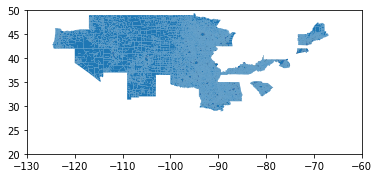

In [12]:
fig,ax = plt.subplots(1,1)
newtestgdf.plot(ax=ax)
plt.xlim(-130,-60)
plt.ylim(20,50)
plt.show()



## WISCONSIN

In [13]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'WI')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# #congressional_districts_bitmask
# # 1 and 2 (x11000000)    14
# # 1 and 4 (x10010000)     2
# # 1 and 5 (x10001000)    29
# # 2 and 3 (x01100000)     5
# # 3 and 7 (x00100010)    36
# # 4 and 5 (x00011000)     4
# # 4 and 6 (x00010100)     2
# # 5 and 6 (x00001100)    16
# # 6 and 8 (x00000101)     4


### Match overlapping districts

In [14]:
# s = time.time()

# this_state = 'WI'
# test_this_bitmask = 'x00000101'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False
# show_water = True

# manual_xlim = (-88.68,-88.5)
# manual_ylim = (43.35,43.5)


# legend_location = 'lower left'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,12))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(24,12))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=13, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=3)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         #& (place_gdf['NAME'].isin(['Rockville']))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
#                    )
# explore_more = b
# oldi = -1
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



### Further investigation

In [15]:
# def parse_road_name(thename):
#     try:
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#     except AttributeError:
#         try: 
#             annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
#         except AttributeError:
#             annotator = thisrow['FULLNAME']
#     return annotator


# road_label_format = { 
#     'I': { 'labelsize': 20, 'thebbox': dict(boxstyle="darrow", fc='white', ec='blue') }, 
#     'U': { 'labelsize': 18, 'thebbox': dict(boxstyle="square", fc='white', ec='red') },
#     'S': { 'labelsize': 16, 'thebbox': dict(boxstyle="round,pad=0.5,rounding_size=1", fc='white', ec='orange')},
#     'C': { 'labelsize': 14, 'thebbox': dict(boxstyle="sawtooth,pad=1", fc='white') }, 
#     'M': { 'labelsize': 10, 'thecolor': 'black'},
#     'O': { 'labelsize': 10, 'thecolor': 'red' }
# }

# print('ok')


In [16]:
# s = time.time()
# label_small_roads = True
# label_small_road_types = ['St', 'Dr', 'Rd'] #['Ave', 'Rd', 'Way']
# show_places = True
# show_water = True
# basesize = 12
# aspect_ratio = xspan / yspan
# #oldi = -1
# i = 2
# map_buffer_ratio = 0.1


# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []



# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]
# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if (oldi != i):
#     map_area_geo = makebox(xlimits, ylimits)

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# #map_area_gdf.plot(ax=ax)

# print('finding water overlap...')
# if (oldi != i):
#     water_in_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if (oldi != i):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# #roads_here_gdf[roads_here_gdf['RTTYP'].isnull()].plot(ax=ax, color='black', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[(roads_in_map_area_gdf['FULLNAME'].notnull()) & (roads_in_map_area_gdf['RTTYP'].isin(['I','U','S','C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()




# oldi = i

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# pprint(suffixes_to_count_dict)
# print(other_roads)
# pprint(this_block_group_id)



### Get water, places, roads

In [17]:
# s = time.time()

# this_state = 'WI'
# this_state_number = 55
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



## MISSOURI

In [18]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'MO')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


# # congressional_districts_bitmask
# # 5 and 6 (x00001100)    35


### Match overlapping districts

In [19]:
# s = time.time()

# this_state = 'MO'
# test_this_bitmask = 'x00001100'

# manual_plot_limits = False
# show_small_roads = True
# show_places = False

# manual_xlim = (-94.61,-94.39)
# manual_ylim = (39.1,39.26)

# legend_location = 'upper right'

# map_buffer_ratio = .1

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(24,12))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(24,12))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='black', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=13, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# print('plotting water...')
# water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax2, color='none', edgecolor='purple', linewidth=3)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         #& (place_gdf['NAME'].isin(['Rockville']))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
#                    )
# explore_more = b
# oldi = 0
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))




### Further investigation

In [20]:
# def parse_road_name(thename):
#     try:
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#     except AttributeError:
#         try: 
#             annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
#         except AttributeError:
#             annotator = thisrow['FULLNAME']
#     return annotator


# road_label_format = { 
#     'I': { 'labelsize': 20, 'thebbox': dict(boxstyle="darrow", fc='white', ec='blue') }, 
#     'U': { 'labelsize': 18, 'thebbox': dict(boxstyle="square", fc='white', ec='red') },
#     'S': { 'labelsize': 16, 'thebbox': dict(boxstyle="round,pad=0.5,rounding_size=1", fc='white', ec='orange')},
#     'C': { 'labelsize': 14, 'thebbox': dict(boxstyle="sawtooth,pad=1", fc='white') }, 
#     'M': { 'labelsize': 10, 'thecolor': 'black'},
#     'O': { 'labelsize': 10, 'thecolor': 'red' }
# }

# print('ok')


In [21]:
# s = time.time()
# label_small_roads = True
# label_small_road_types = ['Dr', 'St', 'Pkwy']
# show_places = False
# show_water = False
# basesize = 12
# aspect_ratio = xspan / yspan
# #oldi = -1
# i = 11
# map_buffer_ratio = 0.1


# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []



# if (oldi != i):
#     print('Running this cell for the first time...')
# this_block_group_id = explore_more[i]
# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_gdf = assembler_gdf[assembler_gdf.index == this_block_group_id]

# total_block_group_area = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.apply(lambda x: x.area).values[0]
# print('Area: {0:,.1f} km^2'.format(total_block_group_area/1000000))

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0], x.bounds[2])).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1], x.bounds[3])).values[0]

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = block_group_gdf.geometry.apply(lambda x: (x.bounds[1] - ybuffer, x.bounds[3] + ybuffer)).values[0]


# if (oldi != i):
#     map_area_geo = makebox(xlimits, ylimits)

# print('Aspect ratio: {0:.3f}'.format(aspect_ratio))
# print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# for j in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[j] == '1'):
#         print('Matching District {0:}...'.format(j))
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].plot(ax=ax, color=district_color_cycle[j-1])
#         overlap_area = geopandas.overlay(block_group_gdf.to_crs(equal_area_crs), cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == j)].to_crs(equal_area_crs), how='intersection').area.values[0]
#         print('\tOverlap area: {0:,.1f} km^2 ({1:.1%})'.format(overlap_area / 1000000, overlap_area / total_block_group_area))
            
            
# print('\n')



# block_group_gdf.plot(ax=ax, color='none', edgecolor='white', lw=8, zorder=100)
# #map_area_gdf.plot(ax=ax)

# print('finding water overlap...')
# if (oldi != i):
#     water_in_map_area_gdf = water_gdf[water_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]
#     #water_here_gdf = geopandas.overlay(water_gdf, block_group_gdf, how='intersection')
# water_in_map_area_gdf.plot(ax=ax, color='blue')

# print('finding road overlap...')
# if (oldi != i):
#     print('\twith block group...')
#     roads_in_block_group_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(block_group_gdf.geometry.values[0]))]
#     print('\twith full map area...')
#     roads_in_map_area_gdf = roads_gdf[roads_gdf.geometry.apply(lambda x: x.intersects(map_area_geo))]


# #roads_here_gdf[roads_here_gdf['RTTYP'].isnull()].plot(ax=ax, color='black', linewidth=0.5) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'].isin(['M', 'O'])].plot(ax=ax, color='black', linewidth=1) 
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'C'].plot(ax=ax, color='black', linewidth=2)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=3)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=4)
# roads_in_map_area_gdf[roads_in_map_area_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=5)


# print('labeling big roads in map area...')
# for ix, thisrow in roads_in_map_area_gdf[(roads_in_map_area_gdf['FULLNAME'].notnull()) & (roads_in_map_area_gdf['RTTYP'].isin(['I','U','S','C']))].iterrows():
#     annotator = parse_road_name(thisrow['FULLNAME'])
#     centerpoint = Point((thisrow.geometry.centroid.x, thisrow.geometry.centroid.y))
#     if (map_area_geo.contains(centerpoint)):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', ha='center', va='center',
#                      fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], bbox=road_label_format[thisrow['RTTYP']]['thebbox'])
    
# if (label_small_roads):    
#     print('labeling small roads in block group...')
#     for ix, thisrow in roads_in_block_group_gdf[(roads_in_block_group_gdf['FULLNAME'].notnull()) & (roads_in_block_group_gdf['RTTYP'].isin(['M', 'O']))].iterrows():
#         #print('\t{0:}'.format(thisrow['FULLNAME']))
#         is_other_road_type = False
#         try:
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1].strip()
#             if (road_suffix in suffixes_to_count_dict):
#                 suffixes_to_count_dict[road_suffix] = suffixes_to_count_dict[road_suffix] + 1
#         except AttributeError:
#             is_other_road_type = True 
#             other_roads.append(thisrow['FULLNAME'])
        
#         if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#             annotator = thisrow['FULLNAME']            
#             plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=road_label_format[thisrow['RTTYP']]['labelsize'], ha='center', va='center')

# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))


# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=24)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# plt.xlim(xlimits)
# plt.ylim(ylimits)

# # plt.xticks(fontsize=24)
# # plt.yticks(fontsize=24)


# plt.show()


# #'15000US290950137031'  5

# oldi = i

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))

# #map_area_geo
# pprint(suffixes_to_count_dict)
# print(other_roads)




### Get water, places, roads

In [22]:
# s = time.time()

# this_state = 'MO'
# this_state_number = 29
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



## MINNESOTA

In [23]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'MN')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


### Match overlapping districts

In [24]:
# s = time.time()

# this_state = 'MN'
# test_this_bitmask = 'x00000011'

# manual_plot_limits = False
# show_small_roads = True
# show_places = True

# manual_xlim = (-93.32,-93.26)
# manual_ylim = (45.1,45.15)



# legend_location = 'upper left'

# map_buffer_ratio = .5

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)


# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=11, ha='center'
#                )
# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# # print('plotting water...')
# # water_gdf.plot(ax=ax2, color='blue')

# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf.plot(ax=ax2, color='none', edgecolor='red', linewidth=3)#color='white', alpha=0.5)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         #& (place_gdf['NAME'].isin(['Rockville']))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=10, ha='center'
#                    )
# explore_more = b
# plt.show()
# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



### Further investigation

In [25]:
# s = time.time()
# label_small_roads = False
# label_small_road_types = []
# show_places = False
# show_water = False
# basesize = 12
# aspect_ratio = xspan / yspan

# i = 3
# need_roads = False

# this_block_group_id = explore_more[i]


# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_geo = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.values[0]
# total_block_group_area = block_group_geo.area
# print('Total area {0:,.1f} km^2...'.format(total_block_group_area / 1000000))
# print('\n')

# if (need_roads):
#     print('Finding roads in this block group...')
#     road_linearids_in_this_block_group_list = []
#     cnt = 0
#     for ix, thisrow in roads_gdf.to_crs(equal_area_crs).iterrows():
#         if ((np.mod(cnt, 50000) == 0) | (cnt == len(roads_gdf) - 1)):
#             print('\tExamining road {0:,.0f} of {1:,.0f} in entire state...'.format(cnt+1, len(roads_gdf)))
#         if (thisrow.geometry.intersects(block_group_geo)):
#             road_linearids_in_this_block_group_list.append(ix)
#         cnt = cnt + 1


# print('Found {0:,.0f} roads in block group {1:}'.format(len(road_linearids_in_this_block_group_list), this_block_group_id))
# print('\n')

# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         print('Matching BG {0:} with district {1:.0f}...'.format(this_block_group_id, i))
#         this_district_overlap_geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].to_crs(equal_area_crs).geometry.apply(lambda x: x.intersection(block_group_geo)).values[0]
#         this_district_overlap_area = this_district_overlap_geo.area
#         print('\tDistrict {0:} overlaps {1:.1%} of the area...'.format(i, this_district_overlap_area / total_block_group_area))        
#         match_road_network_length = 0
#         for jx, thatrow in roads_gdf[
#             (roads_gdf.index.isin(road_linearids_in_this_block_group_list))
# #            & (roads_gdf['RTTYP'] != 'I')
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersects(this_district_overlap_geo)):
#                 match_road_network_length += thatrow.geometry.intersection(this_district_overlap_geo).length
#         road_network_density = match_road_network_length / this_district_overlap_area
#         print('\tDistrict {0:} overlap has {1:,.1f} km roads in {2:.1f} km^2 area (density {3:,.1f}/km)...'.format(i, match_road_network_length/1000, this_district_overlap_area/1000000, 1000*road_network_density))
#         print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# # print('Plotting official districts...')

# # legend_list = []
# # for i in range(1, len(test_this_bitmask)):
# #     if (test_this_bitmask[i] == '1'):
# #         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
# #         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
            
# print('plotting tracts that overlap multiple districts...')
# assembler_gdf[
#     assembler_gdf.index == this_block_group_id
# ].plot(ax=ax, color='none', edgecolor='black', linewidth=10)

# bounding_box = unary_union(
#     assembler_gdf[
#         assembler_gdf.index == this_block_group_id
#     ].geometry.tolist()
# ).bounds
# xlimits = (bounding_box[0], bounding_box[2])
# ylimits = (bounding_box[1], bounding_box[3])

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# # ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
# # ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
# #ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    
# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax, color='blue')

# # print('plotting roads...')
# # roads_gdf[
# #     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'].isnull())
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# # ].plot(ax=ax, color='gray', linewidth=0.3) 
# # roads_gdf[
# #     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (~roads_gdf['RTTYP'].isin(['I','U','S','C']))
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# # ].plot(ax=ax, color='black', linewidth=0.5) 
# # roads_gdf[
# #     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'C')
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# # ].plot(ax=ax, color='black', linewidth=1)
# # roads_gdf[
# #     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'U')
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# # ].plot(ax=ax, color='black', linewidth=3)
# # roads_gdf[
# #     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'I')
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# # #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# # ].plot(ax=ax, color='black', linewidth=5)

# # print('labeling roads...')
# # #unique_names = []
# # for ix, thisrow in roads_gdf[roads_gdf.index.isin(road_linearids_in_this_block_group_list)].iterrows():
# #     has_custom_bbox = False
# #     thefontdict = {}
# #     labelsize = 9
# #     annotator = ''
# #     if (thisrow['RTTYP'] == 'I'):
# #         labelsize = 20
# #         annotator = thisrow['RTTYP']
# #         has_custom_bbox = True
# #         thebbox=dict(boxstyle="darrow", fc='white', ec='blue')
# #     elif (thisrow['RTTYP'] == 'U'):
# #         labelsize = 16
# #         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
# #         has_custom_bbox = True
# #         thebbox=dict(boxstyle="square", fc='white', ec='red')
# #     elif (thisrow['RTTYP'] == 'S'):
# #         labelsize = 14
# #         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
# #         has_custom_bbox = True
# #         thebbox=dict(boxstyle="round,pad=0.5,rounding_size=1", fc='white', ec='orange')
# #     elif (thisrow['RTTYP'] == 'C'):
# #         labelsize = 10
# #         try:
# #             annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
# #             has_custom_bbox = True
# #             thebbox=dict(boxstyle="sawtooth,pad=1", fc='white')
# #         except AttributeError:
# #             pass
# #     elif (label_small_roads):
# #         labelsize = 9
# # #        if (thisrow['FULLNAME'] not in unique_names):
# # #            unique_names.append(thisrow['FULLNAME'])
# #         if (re.search("\s",str(thisrow['FULLNAME'])) != None):
# #             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1]
# #             is_other_road_type = True
# #             for k, v in suffixes_to_count_dict.items():
# #                 if (road_suffix == k):
# #                     suffixes_to_count_dict[k] = suffixes_to_count_dict[k] + 1
# #                     is_other_road_type = False
# #             if (is_other_road_type):
# #                 other_roads.append(thisrow['FULLNAME'])
# #             if ((road_suffix in label_small_road_types) | (is_other_road_type)):
# #                 #if (re.search('(sillery)',thisrow['FULLNAME'].lower()) != None):
# #                 annotator = thisrow['FULLNAME']
# #     if (has_custom_bbox):
# #         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center',
# #                      bbox = thebbox)
# #     else:
# #         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center')

# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=18)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='yellow', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))


# metrobox_gdf = geopandas.GeoDataFrame(data=[[metrobox_geo]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')

# metrobox_gdf.plot(ax=ax, color='None', edgecolor='purple', lw=5)

# plt.xticks(fontsize=28)
# plt.yticks(fontsize=28)

# plt.show()



# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



### Get water, roads, places

In [26]:
# s = time.time()

# this_state = 'MN'
# this_state_number = 27
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



## Establishing shot

In [27]:
# manual_xlim = (-93.9,-92.7)
# manual_ylim = (44.6,45.3)

# def makebox(manual_xlim, manual_ylim):
#     divider_north_lat = manual_ylim[1]
#     divider_south_lat = manual_ylim[0]
#     divider_west_lon = manual_xlim[0]
#     divider_east_lon = manual_xlim[1]
    
#     fig, ax = plt.subplots()
#     nwcorner = Point(divider_west_lon,divider_north_lat)
#     necorner = Point(divider_east_lon,divider_north_lat)
#     swcorner = Point(divider_west_lon,divider_south_lat)
#     secorner = Point(divider_east_lon,divider_south_lat)

#     points = []
#     points.append(Point(divider_west_lon,divider_north_lat))
#     points.append(Point(divider_east_lon,divider_north_lat))
#     points.append(Point(divider_east_lon,divider_south_lat))
#     points.append(Point(divider_west_lon,divider_south_lat))
    
#     coords = [(p.x, p.y) for p in points]    
#     metrobox = Polygon(coords)
    
#     metrobox_gdf = geopandas.GeoDataFrame(data=[[metrobox]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')
#     nwgdf = geopandas.GeoDataFrame(data=[[nwcorner]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')
#     negdf = geopandas.GeoDataFrame(data=[[necorner]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')
#     segdf = geopandas.GeoDataFrame(data=[[secorner]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')
#     swgdf = geopandas.GeoDataFrame(data=[[swcorner]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')
    
#     print(metrobox)
    
#     return metrobox_gdf #nwgdf, negdf, segdf, swgdf
# print('ok')

In [28]:
# s = time.time()

# this_state = 'MN'
# # test_this_bitmask = 'x10000010'
# manual_plot_limits = True

# # show_places = False
# # show_labels = True

# legend_location = 'center left'

# map_buffer_ratio = .05

# fig, ax = plt.subplots(1,1,figsize=(12,12))


# print('Plotting official districts...')

# legend_list = []
# for i in range(1, len(test_this_bitmask)):
#     #if (test_this_bitmask[i] == '1'):
#     cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#     legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# # print('plotting tracts that overlap multiple districts...')
# # for ax in (ax1,ax2):
# #     assembler_gdf[
# #         (assembler_gdf['block_based_district'] == -1)
# #         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# #     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

# print('axising...')
# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# if (manual_plot_limits):
#     xlimits = (manual_xlim[0], manual_xlim[1])
#     ylimits = (manual_ylim[0], manual_ylim[1])
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)

# # else:
# #     bounding_box = unary_union(
# #         cd_gdf.geometry.tolist()
# #     ).bounds
# #     xlimits = (bounding_box[0], bounding_box[2])
# #     ylimits = (bounding_box[1], bounding_box[3])


# # if (manual_plot_limits):
# #     xspan = xlimits[1] - xlimits[0]
# #     yspan = ylimits[1] - ylimits[0]
# #     xbuffer = xspan * map_buffer_ratio
# #     ybuffer = yspan * map_buffer_ratio
# #     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
# #     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)

# ax.legend(handles=legend_list, fontsize=12, loc=legend_location)

# # if (show_labels):
# #     print('labeling block groups...')
# #     #####  add labels for block groups with overlap
# #     b = []
# #     for ix, thisrow in assembler_gdf[
# #         (assembler_gdf['STUSAB'] == this_state) 
# #         & (assembler_gdf['block_based_district'] == -1) 
# #         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# #         & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
# #         & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# #     ].iterrows():
# #         b.append(ix)
# #         annotator = ix[-6:]
# #         ax1.annotate(annotator, 
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      color='black', backgroundcolor='white', fontsize=11, ha='center'
# #                    )
# #     b = sorted(b)
# #     for i in range(0,len(b)):
# #         print(b[i])
# #     print('\n')


# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# # print('plotting roads...')
# # if (show_small_roads):
# #     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# # roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# # roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# # roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# # roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# # if (show_places):
# #     print('plotting places...')
# #     place_gdf[place_gdf['NAME'] == 'Rockville'].plot(ax=ax2, color='none', edgecolor='purple', linewidth=3)#color='white', alpha=0.5)
# #     for ix, thisrow in place_gdf[
# #         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
# #         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
# #         & (place_gdf['NAME'].isin(['Rockville']))
# #     ].sort_values(by='NAME').iterrows():
# #         print('\t{0:}...'.format(thisrow['NAME']))
# #         annotator = thisrow['NAME'].upper()
# #         ax2.annotate(annotator, 
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      color='purple', backgroundcolor='white', fontsize=10, ha='center'
# #                    )


# #(nwgdf, negdf, segdf, swgdf) = 
# metrobox_gdf = makebox(manual_xlim, manual_ylim)

# # nwgdf.plot(color='blue', ax=ax)
# # negdf.plot(color='green', ax=ax)
# # segdf.plot(color='orange', ax=ax)
# # swgdf.plot(color='red', ax=ax)
# metrobox_gdf.plot(ax=ax, color='None', edgecolor='black', lw=3)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

# # explore_more = b

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
# # 


## MARYLAND

In [29]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'MD')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


# # 6 and 8 (x00000101)    43

In [30]:
# s = time.time()

# this_state = 'MD'
# test_this_bitmask = 'x00000101'

# manual_plot_limits = False
# show_small_roads = True
# show_places = True

# manual_xlim = (-77.22,-77.12)
# manual_ylim = (39.09,39.13)



# legend_location = 'upper right'

# map_buffer_ratio = .05

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
# #fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))

# print('Plotting official districts...')
# for ax in (ax1, ax2):
#     legend_list = []
#     for i in range(1, len(test_this_bitmask)):
#         if (test_this_bitmask[i] == '1'):
#             cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#             legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))


# #assembler_gdf[assembler_gdf['STUSAB'] == this_state].plot(ax=ax, color='none', edgecolor='yellow', lw=0.5)

# print('plotting tracts that overlap multiple districts...')
# for ax in (ax1,ax2):
#     assembler_gdf[
#         (assembler_gdf['block_based_district'] == -1)
#         & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#     ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

#     if (manual_plot_limits):
#         xlimits = (manual_xlim[0], manual_xlim[1])
#         ylimits = (manual_ylim[0], manual_ylim[1])
#     else:
#         bounding_box = unary_union(
#             assembler_gdf[
#                 (assembler_gdf['block_based_district'] == -1)
#                 & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
#             ].geometry.tolist()
#         ).bounds
#         xlimits = (bounding_box[0], bounding_box[2])
#         ylimits = (bounding_box[1], bounding_box[3])

#     xspan = xlimits[1] - xlimits[0]
#     yspan = ylimits[1] - ylimits[0]
#     xbuffer = xspan * map_buffer_ratio
#     ybuffer = yspan * map_buffer_ratio
#     ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
#     ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
    
#     ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    
# print('labeling block groups...')
# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     annotator = ix[-6:]
#     ax1.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=11, ha='center'
#                )

# print('plotting water...')
# water_gdf.plot(ax=ax2, color='blue')
# print('plotting roads...')
# if (show_small_roads):
#     roads_gdf[~roads_gdf['RTTYP'].isin(['I','U','S','C'])].plot(ax=ax2, color='black', linewidth=0.25) 
# roads_gdf[roads_gdf['RTTYP'] == 'C'].plot(ax=ax2, color='black', linewidth=0.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax2, color='black', linewidth=1) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax2, color='black', linewidth=1.5) 
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax2, color='black', linewidth=2) 

# if (show_places):
#     print('plotting places...')
#     place_gdf[place_gdf['NAME'] == 'Rockville'].plot(ax=ax2, color='none', edgecolor='red', linewidth=3)#color='white', alpha=0.5)
#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#         & (place_gdf['NAME'].isin(['Rockville']))
#     ].sort_values(by='NAME').iterrows():
#         print('\t{0:}...'.format(thisrow['NAME']))
#         annotator = thisrow['NAME'].upper()
#         ax2.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='red', backgroundcolor='white', fontsize=10, ha='center'
#                    )
# plt.show()

# b = sorted(b)
# for i in range(0,len(b)):
#     print(b[i])

# explore_more = b

# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))



### Further investigation


In [31]:
# s = time.time()
# label_small_roads = True
# label_small_road_types = ['Dr', 'St', 'Blvd']
# show_places = False
# show_water = False
# basesize = 12
# aspect_ratio = xspan / yspan

# i = 0
# need_roads = False

# #this_block_group_id = explore_more[i]
# this_block_group_id = '15000US240217523032'

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0, 'Pkwy': 0, 'Pl': 0 }
# other_roads = []

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_geo = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.values[0]
# total_block_group_area = block_group_geo.area
# print('Total area {0:,.1f} km^2...'.format(total_block_group_area / 1000000))
# print('\n')

# if (need_roads):
#     print('Finding roads in this block group...')
#     road_linearids_in_this_block_group_list = []
#     cnt = 0
#     for ix, thisrow in roads_gdf.to_crs(equal_area_crs).iterrows():
#         if ((np.mod(cnt, 50000) == 0) | (cnt == len(roads_gdf) - 1)):
#             print('\tExamining road {0:,.0f} of {1:,.0f} in entire state...'.format(cnt+1, len(roads_gdf)))
#         if (thisrow.geometry.intersects(block_group_geo)):
#             road_linearids_in_this_block_group_list.append(ix)
#         cnt = cnt + 1


# print('Found {0:,.0f} roads in block group {1:}'.format(len(road_linearids_in_this_block_group_list), this_block_group_id))
# print('\n')

# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         print('Matching BG {0:} with district {1:.0f}...'.format(this_block_group_id, i))
#         this_district_overlap_geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].to_crs(equal_area_crs).geometry.apply(lambda x: x.intersection(block_group_geo)).values[0]
#         this_district_overlap_area = this_district_overlap_geo.area
#         print('\tDistrict {0:} overlaps {1:.1%} of the area...'.format(i, this_district_overlap_area / total_block_group_area))        
#         match_road_network_length = 0
#         for jx, thatrow in roads_gdf[
#             (roads_gdf.index.isin(road_linearids_in_this_block_group_list))
# #            & (roads_gdf['RTTYP'] != 'I')
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersects(this_district_overlap_geo)):
#                 match_road_network_length += thatrow.geometry.intersection(this_district_overlap_geo).length
#         road_network_density = match_road_network_length / this_district_overlap_area
#         print('\tDistrict {0:} overlap has {1:,.1f} km roads in {2:.1f} km^2 area (density {3:,.1f}/km)...'.format(i, match_road_network_length/1000, this_district_overlap_area/1000000, 1000*road_network_density))
#         print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# # print('Plotting official districts...')

# legend_list = []
# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
            
# print('plotting tracts that overlap multiple districts...')
# assembler_gdf[
#     assembler_gdf.index == this_block_group_id
# ].plot(ax=ax, color='none', edgecolor='white', linewidth=10)

# bounding_box = unary_union(
#     assembler_gdf[
#         assembler_gdf.index == this_block_group_id
#     ].geometry.tolist()
# ).bounds
# xlimits = (bounding_box[0], bounding_box[2])
# ylimits = (bounding_box[1], bounding_box[3])

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
# ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
# #ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    
# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (~roads_gdf['RTTYP'].isin(['I','U','S','C']))
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=0.5) 
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'C')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'U')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=3)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'I')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=5)

# print('labeling roads...')
# #unique_names = []
# for ix, thisrow in roads_gdf[roads_gdf.index.isin(road_linearids_in_this_block_group_list)].iterrows():
#     has_custom_bbox = False
#     thefontdict = {}
#     labelsize = 9
#     annotator = ''
#     if (thisrow['RTTYP'] == 'I'):
#         labelsize = 20
#         annotator = thisrow['RTTYP']
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="darrow", fc='white', ec='blue')
#     elif (thisrow['RTTYP'] == 'U'):
#         labelsize = 16
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="square", fc='white', ec='red')
#     elif (thisrow['RTTYP'] == 'S'):
#         labelsize = 14
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="round,pad=0.5,rounding_size=1", fc='white', ec='orange')
#     elif (thisrow['RTTYP'] == 'C'):
#         labelsize = 10
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="sawtooth,pad=1", fc='white')
#     elif (label_small_roads):
#         labelsize = 9
# #        if (thisrow['FULLNAME'] not in unique_names):
# #            unique_names.append(thisrow['FULLNAME'])
#         if (re.search("\s",str(thisrow['FULLNAME'])) != None):
#             road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1]
#             is_other_road_type = True
#             for k, v in suffixes_to_count_dict.items():
#                 if (road_suffix == k):
#                     suffixes_to_count_dict[k] = suffixes_to_count_dict[k] + 1
#                     is_other_road_type = False
#             if (is_other_road_type):
#                 other_roads.append(thisrow['FULLNAME'])
#             if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#                 #if (re.search('(sillery)',thisrow['FULLNAME'].lower()) != None):
#                 annotator = thisrow['FULLNAME']
#     if (has_custom_bbox):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center',
#                      bbox = thebbox)
#     else:
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center')

# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=18)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# if (show_places):
#     print('finding places...')
#     print('\tshowing place names...')
#     for ix, thisrow in place_gdf.iterrows():
#         if (thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry)):
#             print('\t\t',str(thisrow['NAME']))
#     print('\tplotting places...')    
#     place_gdf.plot(ax=ax, color='none', edgecolor='red', lw=5)
#     print('\tlabeling places...')
    

#     for ix, thisrow in place_gdf[
#         ((place_gdf['INTPTLON'] >= xlimits[0] - xbuffer) & (place_gdf['INTPTLON'] <= xlimits[1] + xbuffer))
#         & ((place_gdf['INTPTLAT'] >= ylimits[0] - ybuffer) & (place_gdf['INTPTLAT'] <= ylimits[1] + ybuffer))
#     ].iterrows():
#         annotator = thisrow['NAME'].upper()
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='red', backgroundcolor='white', fontsize=16, ha='center', va='center')


# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))

# plt.show()



# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))




### Get water areas, places, roads

In [32]:
# s = time.time()

# this_state = 'MD'
# this_state_number = 24
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'], errors='coerce')
# place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'], errors='coerce')

# place_gdf = place_gdf.set_index('GEOID')

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')

# # #roads_gdf.head(1).T
# # # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))



In [33]:
### Further investigation    


In [34]:
# s = time.time()
# label_small_roads = True
# label_small_road_types = ['Blvd'] 
# basesize = 8
# aspect_ratio = xspan / yspan

# i = 2
# this_block_group_id = explore_more[i]

# suffixes_to_count_dict = {'Rd': 0, 'Dr': 0, 'St': 0,'Ave': 0, 'Blvd': 0, 'Ln': 0, 'Cir': 0, 'Way': 0, 'Ct': 0 }
# other_roads = []

# print('Examining block group {0:}'.format(this_block_group_id))
# print('Population: {0:,.0f}'.format(assembler_gdf.loc[this_block_group_id]['total_population']))

# block_group_geo = assembler_gdf[assembler_gdf.index == this_block_group_id].to_crs(equal_area_crs).geometry.values[0]
# total_block_group_area = block_group_geo.area
# print('Total area {0:,.1f} km^2...'.format(total_block_group_area / 1000000))
# print('\n')

# # print('Finding roads in this block group...')
# # road_linearids_in_this_block_group_list = []
# # cnt = 0
# # for ix, thisrow in roads_gdf.to_crs(equal_area_crs).iterrows():
# #     if ((np.mod(cnt, 50000) == 0) | (cnt == len(roads_gdf) - 1)):
# #         print('\tExamining road {0:,.0f} of {1:,.0f} in entire state...'.format(cnt+1, len(roads_gdf)))
# #     if (thisrow.geometry.intersects(block_group_geo)):
# #         road_linearids_in_this_block_group_list.append(ix)
# #     cnt = cnt + 1

# print('Found {0:,.0f} roads in block group {1:}'.format(len(road_linearids_in_this_block_group_list), this_block_group_id))
# print('\n')

# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         print('Matching BG {0:} with district {1:.0f}...'.format(this_block_group_id, i))
#         this_district_overlap_geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].to_crs(equal_area_crs).geometry.apply(lambda x: x.intersection(block_group_geo)).values[0]
#         this_district_overlap_area = this_district_overlap_geo.area
#         print('\tDistrict {0:} overlaps {1:.1%} of the area...'.format(i, this_district_overlap_area / total_block_group_area))        
#         match_road_network_length = 0
#         for jx, thatrow in roads_gdf[
#             (roads_gdf.index.isin(road_linearids_in_this_block_group_list))
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersects(this_district_overlap_geo)):
#                 match_road_network_length += thatrow.geometry.intersection(this_district_overlap_geo).length
#         road_network_density = ((match_road_network_length)**2) / this_district_overlap_area
#         print('\tDistrict {0:} overlap has {1:,.1f} km roads (density {2:,.1f})...'.format(i, match_road_network_length/1000, road_network_density))
#         print('\n')

# fig, ax = plt.subplots(1,1,figsize=(basesize*aspect_ratio,basesize))


# print('Plotting official districts...')

# legend_list = []
# for i in range(1, len(test_this_bitmask)):
#     if (test_this_bitmask[i] == '1'):
#         cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == i)].plot(ax=ax, color=district_color_cycle[i-1], label='District {0:.0f}'.format(i))#, alpha=0.5)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i-1], label='District {0:,.0f}'.format(i)))
            
# print('plotting tracts that overlap multiple districts...')
# assembler_gdf[
#     assembler_gdf.index == this_block_group_id
# ].plot(ax=ax, color='none', edgecolor='white', linewidth=10)

# bounding_box = unary_union(
#     assembler_gdf[
#         assembler_gdf.index == this_block_group_id
#     ].geometry.tolist()
# ).bounds
# xlimits = (bounding_box[0], bounding_box[2])
# ylimits = (bounding_box[1], bounding_box[3])

# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# ax.set_xlim(xlimits[0] - xbuffer, xlimits[1] + xbuffer)
# ax.set_ylim(ylimits[0] - ybuffer, ylimits[1] + ybuffer)
# #ax.legend(handles=legend_list, fontsize=12, loc=legend_location)
    

# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (~roads_gdf['RTTYP'].isin(['I','U','S','C']))
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=0.5) 
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'C')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'U')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=3)
# roads_gdf[
#     (roads_gdf.index.isin(road_linearids_in_this_block_group_list)) & (roads_gdf['RTTYP'] == 'I')
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[0]) >= xlimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[2]) <= xlimits[1] + map_buffer) )
# #     & ( (roads_gdf.geometry.apply(lambda x: x.bounds[1]) >= ylimits[0] - map_buffer) & (roads_gdf.geometry.apply(lambda x: x.bounds[3]) <= ylimits[1] + map_buffer) )
# ].plot(ax=ax, color='black', linewidth=5)

# print('labeling roads...')
# unique_names = []
# for ix, thisrow in roads_gdf[roads_gdf.index.isin(road_linearids_in_this_block_group_list)].iterrows():
#     has_custom_bbox = False
#     thefontdict = {}
#     labelsize = 9
#     annotator = ''
#     if (thisrow['RTTYP'] == 'I'):
#         labelsize = 20
#         annotator = thisrow['RTTYP']
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="darrow", fc='white', ec='blue')
#     elif (thisrow['RTTYP'] == 'U'):
#         labelsize = 16
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="square", fc='white', ec='red')
#     elif (thisrow['RTTYP'] == 'S'):
#         if ('42-679' in thisrow['FULLNAME']):
#             labelsize = 14
#             annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#             has_custom_bbox = True
#             thebbox=dict(boxstyle="round,pad=0.5,rounding_size=1", fc='white', ec='orange')
#     elif (thisrow['RTTYP'] == 'C'):
#         labelsize = 10
#         annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
#         has_custom_bbox = True
#         thebbox=dict(boxstyle="sawtooth,pad=1", fc='white')
#     elif (label_small_roads):
#         labelsize = 9
#         if (thisrow['FULLNAME'] not in unique_names):
#             unique_names.append(thisrow['FULLNAME'])
#             if (re.search("\s",str(thisrow['FULLNAME'])) != None):
#                 road_suffix = thisrow['FULLNAME'][::-1][:re.search("\s",thisrow['FULLNAME'][::-1]).start()][::-1]
#                 is_other_road_type = True
#                 for k, v in suffixes_to_count_dict.items():
#                     if (road_suffix == k):
#                         suffixes_to_count_dict[k] = suffixes_to_count_dict[k] + 1
#                         is_other_road_type = False
#                 if (is_other_road_type):
#                     other_roads.append(thisrow['FULLNAME'])
#                 if ((road_suffix in label_small_road_types) | (is_other_road_type)):
#                     annotator = thisrow['FULLNAME']
#     if (has_custom_bbox):
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center',
#                      bbox = thebbox)
#     else:
#         plt.annotate(annotator, (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                      color='black', backgroundcolor='white', fontsize=labelsize, ha='center', va='center')

# plt.title("Block Group {0:}".format(this_block_group_id), fontsize=18)

# if (label_small_roads):
#     print("\tAnalysis of road names:")
#     for k,v in suffixes_to_count_dict.items():
#         print('\t\t{0:}: {1:,.0f}'.format(k,v))
#     print('\tOther road names:')
#     for x in other_roads:
#         print('\t\t',x)
#     print('\n')

# # print('plotting places...')
# # place_gdf[place_gdf.geometry.apply(lambda x: x.intersects(assembler_gdf.loc[this_block_group_id].geometry))].plot(ax=ax, color='purple', edgecolor='none')
    
    
# print('http://maps.google.com/maps?ll={1:.3f},{0:.3f}&spn={2:.3f},{3:.3f}&t=m'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2, xspan, yspan))
# print('\n')
# plt.show()



# e = time.time()
# g = g + (e-s)
# print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))




In [35]:
# for ix, thisrow in place_gdf.iterrows():
#     if thisrow.geometry.intersects(assembler_gdf.loc[this_block_group_id].geometry):
#         print(thisrow['NAME'])
#         print('\n')

### Read water areas, places, roads